In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Start = "2015-01-01"
Today = date.today().strftime("%Y-%m-%d")

# Getting the stock price data from Yahoo Finance
ticker = 'AAPL'
data = yf.download(ticker, Start, Today)
df = data
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565695,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873648,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875885,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210682,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140913,237458000
...,...,...,...,...,...,...
2023-04-24,165.000000,165.600006,163.889999,165.330002,165.330002,41949600
2023-04-25,165.190002,166.309998,163.729996,163.770004,163.770004,48714100
2023-04-26,163.059998,165.279999,162.800003,163.759995,163.759995,45498800


In [4]:
# Preprocessing the data
# Resample to daily frequency, forward fill missing values, and drop any remaining NaNs
data = data['Close'].resample('D').ffill().dropna()

# Scaling the data
scaler = MinMaxScaler()
data = scaler.fit_transform(np.array(data).reshape(-1, 1))

# Creating the features and target variables
lookback = 60 # Number of days to look back
X = []
y = []
for i in range(lookback, len(data)):
    X.append(data[i-lookback:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)

In [5]:
# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshaping the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(X_train)
print("***********")
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test

[[[0.0297789 ]
  [0.0297789 ]
  [0.0297789 ]
  ...
  [0.05977734]
  [0.05977734]
  [0.06076525]]

 [[0.0297789 ]
  [0.0297789 ]
  [0.02494904]
  ...
  [0.05977734]
  [0.06076525]
  [0.06118866]]

 [[0.0297789 ]
  [0.02494904]
  [0.02496473]
  ...
  [0.06076525]
  [0.06118866]
  [0.05990277]]

 ...

 [[0.76854323]
  [0.76854323]
  [0.76854323]
  ...
  [0.82618791]
  [0.82618791]
  [0.82618791]]

 [[0.76854323]
  [0.76854323]
  [0.76471698]
  ...
  [0.82618791]
  [0.82618791]
  [0.84117928]]

 [[0.76854323]
  [0.76471698]
  [0.77186767]
  ...
  [0.82618791]
  [0.84117928]
  [0.83126866]]]
***********


array([[[0.76471698],
        [0.77186767],
        [0.79388426],
        ...,
        [0.84117928],
        [0.83126866],
        [0.82474525]],

       [[0.77186767],
        [0.79388426],
        [0.78968167],
        ...,
        [0.83126866],
        [0.82474525],
        [0.79275525]],

       [[0.79388426],
        [0.78968167],
        [0.77657208],
        ...,
        [0.82474525],
        [0.79275525],
        [0.79275525]],

       ...,

       [[0.77857934],
        [0.77857934],
        [0.78616906],
        ...,
        [0.89342957],
        [0.89537404],
        [0.88558889]],

       [[0.77857934],
        [0.78616906],
        [0.7829701 ],
        ...,
        [0.89537404],
        [0.88558889],
        [0.88552611]],

       [[0.78616906],
        [0.7829701 ],
        [0.76979772],
        ...,
        [0.88558889],
        [0.88552611],
        [0.91469348]]])

In [6]:
# Creating the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mse')

In [7]:
# Fitting the model to the data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
75/75 [==============================] - 9s 73ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 2/100
75/75 [==============================] - 5s 61ms/step - loss: 3.8315e-04 - val_loss: 0.0025
Epoch 3/100
75/75 [==============================] - 4s 60ms/step - loss: 3.3754e-04 - val_loss: 0.0019
Epoch 4/100
75/75 [==============================] - 4s 59ms/step - loss: 3.7764e-04 - val_loss: 0.0016
Epoch 5/100
75/75 [==============================] - 5s 61ms/step - loss: 3.9794e-04 - val_loss: 0.0013
Epoch 6/100
75/75 [==============================] - 4s 60ms/step - loss: 2.8012e-04 - val_loss: 0.0016
Epoch 7/100
75/75 [==============================] - 5s 61ms/step - loss: 3.0703e-04 - val_loss: 0.0011
Epoch 8/100
75/75 [==============================] - 5s 62ms/step - loss: 2.5690e-04 - val_loss: 0.0011
Epoch 9/100
75/75 [==============================] - 5s 66ms/step - loss: 2.2413e-04 - val_loss: 0.0015
Epoch 10/100
75/75 [==============================] - 5s 63ms/step -

Epoch 77/100
75/75 [==============================] - 5s 62ms/step - loss: 8.9182e-05 - val_loss: 3.0930e-04
Epoch 78/100
75/75 [==============================] - 5s 63ms/step - loss: 6.3520e-05 - val_loss: 4.8760e-04
Epoch 79/100
75/75 [==============================] - 5s 64ms/step - loss: 6.4594e-05 - val_loss: 2.9565e-04
Epoch 80/100
75/75 [==============================] - 5s 67ms/step - loss: 8.1589e-05 - val_loss: 2.8421e-04
Epoch 81/100
75/75 [==============================] - 5s 67ms/step - loss: 9.3150e-05 - val_loss: 2.6591e-04
Epoch 82/100
75/75 [==============================] - 5s 67ms/step - loss: 7.6251e-05 - val_loss: 8.9356e-04
Epoch 83/100
75/75 [==============================] - 5s 68ms/step - loss: 6.3005e-05 - val_loss: 4.3898e-04
Epoch 84/100
75/75 [==============================] - 5s 64ms/step - loss: 7.1541e-05 - val_loss: 2.7653e-04
Epoch 85/100
75/75 [==============================] - 5s 68ms/step - loss: 9.7900e-05 - val_loss: 8.8909e-04
Epoch 86/100
75/75 

In [8]:
model.save('keras_LSTM_model.h5')

In [9]:
# Predicting the stock prices for the test set
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

19/19 [==============================] - 1s 19ms/step


In [10]:
df = df.reset_index()
df.head()

# Moving average 100 calculation
ma100 = df.Close.rolling(100).mean()

# Moving average 200 calculation
ma200 = df.Close.rolling(200).mean()

(2095, 7)

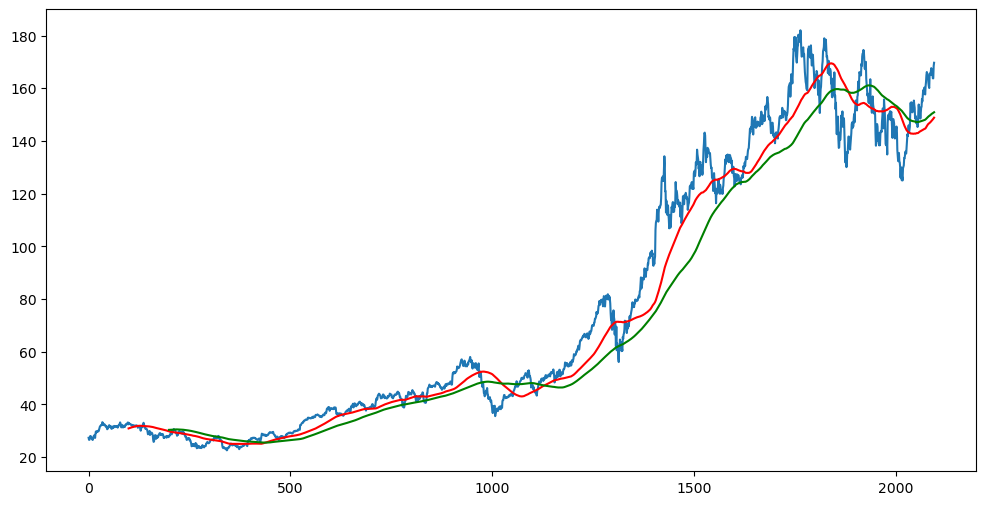

In [11]:
# Chart for ma100 and ma200
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')
df.shape

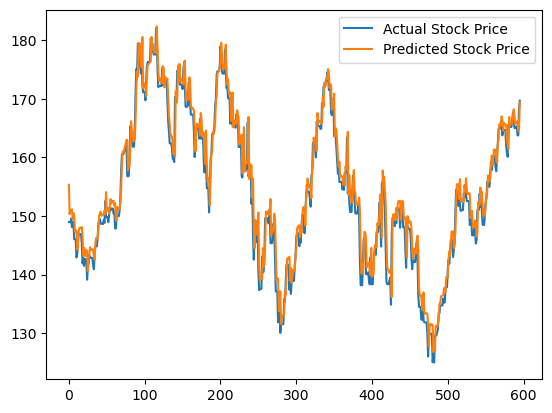

In [12]:
# Visualizing the results
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Stock Price')
plt.plot(predicted_stock_prices, label='Predicted Stock Price')
plt.legend()
plt.show()